In this assignment you have to experiment with letter-to-phoneme conversion. This task is an important part of speech technologies including recognition and synthesis.

The language is French, but you are not expected to know French to do well in this task.

Let's first download the data:

In [49]:
! wget --no-check-certificate https://bark.phon.ioc.ee/tanel/tmp/fre_train.tsv
! wget --no-check-certificate https://bark.phon.ioc.ee/tanel/tmp/fre_dev.tsv
! wget --no-check-certificate https://bark.phon.ioc.ee/tanel/tmp/fre_test.unlabelled.tsv

--2023-05-11 19:05:17--  https://bark.phon.ioc.ee/tanel/tmp/fre_train.tsv
Resolving bark.phon.ioc.ee (bark.phon.ioc.ee)... 193.40.251.129
Connecting to bark.phon.ioc.ee (bark.phon.ioc.ee)|193.40.251.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79465 (78K) [text/tab-separated-values]
Saving to: ‘fre_train.tsv.1’

fre_train.tsv.1     100%[===================>]  77.60K   183KB/s    in 0.4s    

2023-05-11 19:05:20 (183 KB/s) - ‘fre_train.tsv.1’ saved [79465/79465]

--2023-05-11 19:05:20--  https://bark.phon.ioc.ee/tanel/tmp/fre_dev.tsv
Resolving bark.phon.ioc.ee (bark.phon.ioc.ee)... 193.40.251.129
Connecting to bark.phon.ioc.ee (bark.phon.ioc.ee)|193.40.251.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9925 (9.7K) [text/tab-separated-values]
Saving to: ‘fre_dev.tsv.1’

fre_dev.tsv.1       100%[===================>]   9.69K  --.-KB/s    in 0.1s    

2023-05-11 19:05:22 (69.2 KB/s) - ‘fre_dev.tsv.1’ saved [9925/9925]

--2023-

Let's explore the data:

In [50]:
!head fre_train.tsv

abandonner	a b ɑ̃ d ɔ n e
abby	a b i
abidjan	a b i d ʒ ɑ̃
abject	a b ʒ ɛ k t
abolir	a b ɔ l i ʁ
abonnement	a b ɔ n m ɑ̃
abou	a b u
absence	a p s ɑ̃ s
absolument	a p s ɔ l y m ɑ̃
absolus	a p s ɔ l y


In [51]:
!head fre_dev.tsv

absent	a p s ɑ̃
abîme	a b i m
accéder	a k s e d e
accélérer	a k s e l e ʁ e
achat	a ʃ a
action	a k s j ɔ̃
activité	a k t i v i t e
adorner	a d ɔ ʁ n e
agence	a ʒ ɑ̃ s
aile	ɛ l


In [52]:
!head fre_test.unlabelled.tsv

tandis
serres
enfer
réunion
moderne
star
classique
bientôt
bouddhiste
défaut


As you see, the data consists of lines. On each line there is a word and its pronunciation, seperated by TABs. Pronunciation consists of IPA-like symbols, seperated by space. The test data is unlabelled, i.e., the pronunciations are not given.

We use the datasets package that is good for handling this kind of data.

In [53]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
import torch

In [55]:
from datasets import load_dataset
# define field names for each column in the CSV files
field_names = ["chars", "phonemes"]
# load train, dev and test datasets from CSV files
data = load_dataset('csv', data_files={'train': 'fre_train.tsv', 'dev': 'fre_dev.tsv'}, delimiter='\t', column_names=field_names)

test_word_list = [l.strip() for l in open("fre_test.unlabelled.tsv")]

  0%|          | 0/2 [00:00<?, ?it/s]

In [56]:
data

DatasetDict({
    train: Dataset({
        features: ['chars', 'phonemes'],
        num_rows: 3600
    })
    dev: Dataset({
        features: ['chars', 'phonemes'],
        num_rows: 450
    })
})

In [57]:
data["train"][0]["phonemes"]

'a b ɑ̃ d ɔ n e'

In [58]:
# define a function to split both fields to a list of characters
def split_chars(example):
    example['chars'] = list(example['chars'])
    example['phonemes'] = example['phonemes'].split()
    return example

data = data.map(split_chars, batched=False)    

In [59]:
train_dataset = data["train"]
dev_dataset = data["dev"]


Let's explore the datasets:

In [60]:
print(len(train_dataset))
print(train_dataset[0]["chars"], train_dataset[0]["phonemes"])

3600
['a', 'b', 'a', 'n', 'd', 'o', 'n', 'n', 'e', 'r'] ['a', 'b', 'ɑ̃', 'd', 'ɔ', 'n', 'e']


Now let's build the char-to-id and phoneme-to-id mappings.

In [61]:
from torchtext.vocab import vocab
from torchtext.vocab import build_vocab_from_iterator

chars_vocab = build_vocab_from_iterator(train_dataset["chars"], min_freq=1, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>'))
phoneme_vocab = build_vocab_from_iterator(train_dataset["phonemes"], min_freq=1, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>'))

In [62]:
chars_vocab.get_itos()

['<unk>',
 '<BOS>',
 '<EOS>',
 '<PAD>',
 'e',
 'r',
 'i',
 'a',
 'n',
 't',
 'o',
 's',
 'l',
 'c',
 'u',
 'm',
 'p',
 'é',
 'd',
 'g',
 'b',
 'v',
 'f',
 'h',
 'q',
 'x',
 'è',
 'y',
 'j',
 'k',
 'z',
 'ê',
 'ô',
 'î',
 'â',
 'ï',
 'ç',
 'w',
 'û',
 'ë',
 'à']

In [63]:
phoneme_vocab.get_itos()

['<unk>',
 '<BOS>',
 '<EOS>',
 '<PAD>',
 'ʁ',
 'a',
 'i',
 's',
 't',
 'e',
 'l',
 'k',
 'ɛ',
 'ɔ',
 'ɑ̃',
 'p',
 'm',
 'd',
 'j',
 'n',
 'ɔ̃',
 'y',
 'v',
 'b',
 'f',
 'ʒ',
 'z',
 'ɛ̃',
 'u',
 'ə',
 'o',
 'ɡ',
 'w',
 'ʃ',
 'œ',
 'ɥ',
 'ø',
 'ɑ',
 'ɲ',
 'œ̃',
 'ŋ',
 'h',
 'ɪ',
 '‿']

In [64]:
chars_vocab(["a", "b"])

[7, 20]

In [65]:
chars_vocab["<PAD>"]

3

In [66]:
device = 'cpu'
if torch.cuda.is_available():
  device = torch.device('cuda')

print(device)

cuda


Let's define the collate function for batching:

In [67]:
import torch
from torch.nn.utils.rnn import pad_sequence

# define a collate function to tokenize and pad the text fields
def collate_fn(batch):
  chars = [torch.Tensor(chars_vocab(["<BOS>"]  + example['chars'] +  ["<EOS>"])).long() for example in batch]
  phonemes = [torch.Tensor(phoneme_vocab(["<BOS>"] +  example['phonemes'] + ["<EOS>"])).long() for example in batch]
  return {
    'chars': pad_sequence(chars, batch_first=True, padding_value=chars_vocab['<PAD>']),
    'phonemes': pad_sequence(phonemes, batch_first=True, padding_value=phoneme_vocab['<PAD>'])
  }

In [68]:
collate_fn([train_dataset[0], train_dataset[1]])

{'chars': tensor([[ 1,  7, 20,  7,  8, 18, 10,  8,  8,  4,  5,  2],
         [ 1,  7, 20, 20, 27,  2,  3,  3,  3,  3,  3,  3]]),
 'phonemes': tensor([[ 1,  5, 23, 14, 17, 13, 19,  9,  2],
         [ 1,  5, 23,  6,  2,  3,  3,  3,  3]])}

Each batch is now a map with two keys (chars and phonemes) which each are both tensors (matrices).

We will first implement a basic encoder-decoder model for this task. Both encoder and decoder have an embedding layer and a recurrent (GRU) layer. The last hidden state of the GRU layer of the encoder is passed to the decoder, which then generates the pronunication from this representation.

The picture below describes this model: an input character sequence "abou" is transformed to a phoneme sequence "abu". Note how the outputs of the encoder GRU are completely ignored by the decoder.

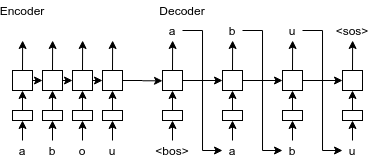

In [ ]:
import math
from torch import Tensor
import torch.nn as nn
from torch.nn import Transformer

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
UNK_IDX, BOS_IDX, EOS_IDX, PAD_IDX = 0, 1, 2, 3

In [69]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout: float, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(1e4)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
        Returns:
            Tensor, shape [batch_size, seq_len, d_model]
        """
        x = self.dropout(x + self.pe[:, :x.size(1), :])
        return x

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
        self.layer_norm = nn.LayerNorm(emb_size)

    def forward(self, tokens: Tensor):
        embed = self.embedding(tokens.long()) * math.sqrt(self.emb_size)
        return self.layer_norm(embed)


# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout,
                                       batch_first=True)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.layer_norm = nn.LayerNorm(emb_size)


    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        src_emb = self.layer_norm(src_emb)
        tgt_emb = self.layer_norm(tgt_emb)
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)
        
    def clip_gradients(self, max_norm: float):
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm)

During training, we need a subsequent word mask that will prevent the model from looking into
the future words when making predictions. We will also need masks to hide
source and target padding tokens.




In [70]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Let's now define the parameters of our model and instantiate the same.




In [71]:
SRC_VOCAB_SIZE = len(chars_vocab)
TGT_VOCAB_SIZE = len(phoneme_vocab)
EMB_SIZE = 1024
FFN_HID_DIM = 1024
NHEAD = 16
BATCH_SIZE = 16
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.AdamW(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)

Let's define training and evaluation loop that will be called for each
epoch.




In [72]:
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

def train_epoch(model, optimizer, scheduler):
    model.train()
    losses = 0
    train_dataloader = DataLoader(data["train"], batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for batch in tqdm(train_dataloader, desc="Training for one epoch"):
        src = batch["chars"].to(DEVICE)
        tgt = batch["phonemes"].to(DEVICE)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        transformer.clip_gradients(1.0)
        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def eval(model):
    model.eval()
    losses = 0

    val_dataloader = DataLoader(data["dev"], batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for batch in val_dataloader:
        src = batch["chars"].to(DEVICE)
        tgt = batch["phonemes"].to(DEVICE)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

Now we have everything to train our model.




In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 80

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, scheduler)
    val_loss = eval(transformer)
    scheduler.step(val_loss)
    end_time = timer()

    print(f'Epoch: {epoch+1:02} | Time: {(end_time - start_time):.3f}s')
    print(f'\tTrain Loss: {train_loss:.4f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {val_loss:.4f} |  Val. PPL: {math.exp(val_loss):7.3f}')

Training for one epoch:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch: 1, Train loss: 2.8739, Val loss: 2.4795, Epoch time = 17.271s


Training for one epoch:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch: 2, Train loss: 1.9645, Val loss: 1.8118, Epoch time = 12.644s


Training for one epoch:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch: 3, Train loss: 1.2014, Val loss: 0.9951, Epoch time = 12.585s


Training for one epoch:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.8352, Val loss: 0.7970, Epoch time = 13.823s


Training for one epoch:   0%|          | 0/225 [00:00<?, ?it/s]

Let's define functions for decoding a test sentence:

In [ ]:
# Greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[-1:, 0])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys

# Beam search algorithm
def beam_search_decode(model, src, src_mask, max_len, start_symbol, beam_size=5):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    memory = memory.to(DEVICE)
    tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                .type(torch.bool)).to(DEVICE)
    out = model.decode(ys, memory, tgt_mask)
    out = out.transpose(0, 1)
    prob = model.generator(out[-1:, 0])
    values, indices = torch.topk(prob, beam_size)
    next_word = indices[0][0].item()

    ys = torch.cat([ys,
                    torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    if next_word == EOS_IDX:
        return ys
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[-1:, 0])
        values, indices = torch.topk(prob, beam_size)
        candidates = []
        for k in range(beam_size):
            value = values[0][k].item()
            index = indices[0][k].item()
            candidate = {'seq': torch.cat([ys,
                                           torch.ones(1, 1).type_as(src.data).fill_(index)], dim=1),
                         'score': value}
            candidates.append(candidate)
        candidates = sorted(candidates, key=lambda x: x['score'], reverse=True)
        ys = candidates[0]['seq']
        next_word = ys[0][len(ys[0])-1].item()
        if next_word == EOS_IDX:
            break
    return ys


In [ ]:
def chars2phonemes(model: torch.nn.Module, word, search_algorithm: str = "greedy", max_len=50):
    model.eval()
    chars = torch.Tensor([chars_vocab(["<BOS>"] + list(word) + ["<EOS>"])]).long().to(device)
    
    num_tokens = chars.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

    if search_algorithm == "greedy":
        tgt_tokens = greedy_decode(
        model, chars, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
        tgt_phoneme = [phoneme_vocab.get_itos()[i] for i in tgt_tokens]
    elif search_algorithm == "beam":
        tgt_tokens = beam_search_decode(
            model, chars, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX, beam_size=5)
        tgt_phoneme = [phoneme_vocab.get_itos()[i] for i in tgt_tokens[0]]
    else:
        raise ValueError("Unknown search algorithm")

    return " ".join(tgt_phoneme[1:-1])

In [ ]:
chars2phonemes(transformer, "appartement", search_algorithm="beam")

This should be a correct pronunciation ('a p a ʁ t ə m ɑ̃').

Now, we implement scoring functionality that allows to evaluate our model based on *phoneme error rate* (how many phonemes in the output are correct, compared to the reference). We use the implementation in jiwer package. The appropriate function is called `wer` (word error rate) because this is typically used to measure the word error rate of a speech recognition system.

In [ ]:
! pip install jiwer

In [ ]:
import jiwer
ref = "a b a c"
hyp = "a b a d"
jiwer.wer(ref, hyp)

Both substitution, insertion and deletion errors are taken into account when computing WER:

In [ ]:
ref = "a b a c"
hyp = "a b a a c"
jiwer.wer(ref, hyp)

0.25

In [ ]:
ref = "a b a c"
hyp = "a b c"
jiwer.wer(ref, hyp)

0.25

Finally, the function that computes the scoring metrics based on the development set:

In [ ]:
def per(model):
  refs = [] 
  hyps = []
  for item in iter(dev_dataset):
    ref = " ".join(item["phonemes"])
    hyp = chars2phonemes(transformer, "".join(item["chars"]), beam_search_decode)
    refs.append(ref)
    hyps.append(hyp)

  per = jiwer.wer(refs, hyps)
  print(f"Phoneme error rate: {per}")

In [ ]:
per(transformer)

Phoneme error rate: 0.19855884707766214


Finally, we implement a function that applies the model to our test data and saves it is a file called `submission.tsv`.

In [ ]:
def make_submission(model):
  with open("submission.tsv", "w") as f:
    print("Word\tPhonemes", file=f)
    for word in test_word_list:
      hyp = chars2phonemes(word, model)
      print(f"{word}\t{hyp}", file=f)


In [ ]:
make_submission(model)

In [ ]:
!head submission.tsv

Word	Phonemes
tandis	t ɑ̃ d i
serres	s ɛ ʁ
enfer	ɑ̃ f ɛ ʁ
réunion	ʁ e y n i z ɔ̃
moderne	m ɔ d ɛ ʁ
star	s t a ʁ
classique	k a l s k a
bientôt	b j ɑ̃ t
bouddhiste	b u d d i s t


## Your assignment

Your task is to improve the performance of the baseline model. You can use any method do this, with the following exceptions:
  * You cannot use some some pretrained model that you found on the Internet that already does this task
  * You cannot use additional French data for training
  * You have to stick to basic Pytorch, and not use libraries that implement whole models for you (you can copy/paste code from there though, as long as you understand what this code is doing)
  * You cannot hand-label additional data
  * You are not allowed to fold the dev set into training data

Some things you can do:

  * Tune basic learning hyperparametes, such as number of epochs, learning rate, optimizer
  * Tune model architecture (number of outputs in the layers, number of layers, etc)
  * Add regularization (dropout, etc)

But the most lucrative thing to try is to implement attention mechanism.  In the baseline model, decoder has to generate a pronunciation solely based on the hidden state passed from the encoder.

You should try to implement attention mechanism between the encoder and decoder.

More specifically, decoder should at each time step generate a new weighted view over the encoder GRU outputs (that are luckily already passed to the decoder's forward method). You should use the query-key-value based attention: output from the decoder's GRU is passed through a (learnable) linear transform that results in a query vector $q$. Another linear transform is applied to encoder outputs that results in key vectors $k_i$. Note that query and keys should have the same dimensionality. Now the query is compared to the keys (using dot product) and the results is softmaxed, resulting in attention weights $w_i$ over the encoder outputs. Encoder outputs are now passed through another linear transform (resulting in $v_i$ ) and summed up to form $v*$, using the computed weights. 


Luckily, most of the attention functionality is implemented in torch's `nn.MultiheadAttention` class. You just have to take care of the linear transforms and some other stuff.

The picture below describes this. Note how how the decoder generates a character "a" based on the output from it's GRU *and* the output $v*$ from the attention mechanism.

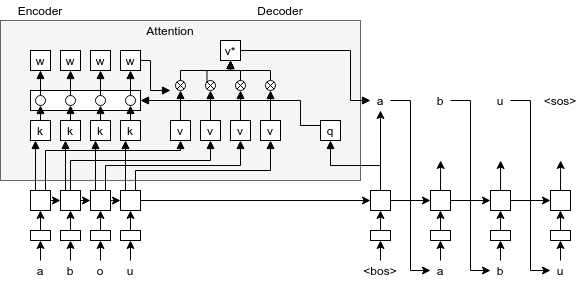

You only need modify the Decoder to implement this. 



If implemented correctly, your phoneme error rate around 0.04 ... 0.08 (actually different training runs give quite different results). That is, attention really works very well in this task, compared to the more basic models.

**Another thing that you should try is to use the Transformer architecture**, i.e., get rid of the GRU layers in both encoder and decoder completely. You should also then use positional encoding in both encoder and decoder. There are plenty of tutorials and code samples about this, and see our lab about Machine Translation!



## Grading

In order to be graded, you have to submit the generated test pronunciations (i.e., the `submission.tsv` file generated by you improved model) to the evaluation leaderboard at http://bark.phon.ioc.ee/am3-leaderboard/. 

In the leaderboard, you have to enter your UniID and upload the generated `submission.tsv` file. *NB!* If you don't feel comfortable that other students see your score, use a nickname (i.e., could be random string only you know), but please be consistent, that is, use only one name across all your submissions. If you use a nickname, let me know what it is when you submit your code.

*Another NB!* The leaderboard is totally unsecure and you don't even have to authenticate yourself, so please don't do stupid things, like uploading under other people's names, etc.

Your grade is determined by the error rate of your best model on test data, compared to the average score of the top 3 students. 

More specifially:
  * First, the average of the top 3 students' models will be computed. Let's call it $score_{top3}$. Let's also save the error rate of the baseline model to $score_{baseline}$.
  * Then, we'll compute how much of the error rate reduction does your best score $score_i$ achieve  over the baseline, when baseline would give you 0% points and $score_{top3}$ 100% points. 
  * That is, your points will be calculated as $max(15, \delta * 15)$, where 
  $\delta=\frac{score_{baseline} - score_{i}}{score_{baseline} - score_{top3}}$
  * For example: baseline score is 0.18, top3 average  is 0.07, and your score 0.11. This would give you $\delta=\frac{0.18-0.11}{0.18-0.07}=0.63$ and $0.63 \times 15 = 9.6 ≃ 10$ points.
  


### More rules!

  * You can make *up to 20 submissions* to the leaderboard
  * The leaderboard $score_{top3}$ will be taken at the time of the assignment deadline. Later submissions that make it to the top 3 will not change it.

You should also submit the jupyter notebook (link) that reproduces your best model. Note that it's expected that multiple runs of the training won't have the same results. 

Please make sure that you share your notebook's link so that "anyone with the link" can see it.